# Reproducibility meets randomness

Ensuring reproducibility in computational social science experiments when randomness is involved is crucial. This tutorial will cover various techniques to achieve reproducibility in Python programs that utilize randomness, primarily focusing on NumPy. We will use the following packages.

In [1]:
import numpy as np
import sys, os
import pickle
from matplotlib import pyplot as plt

## Random states in NumPy

We first look at a simple example of experiment where randomness is involved. In this example we generate an  Erdos-Renyi graph with the number of nodes $n$ and the probability of edge creation $p$.

In [2]:
# Parameters
n = 1000  # Number of nodes
p = 0.2   # Probability of edge creation

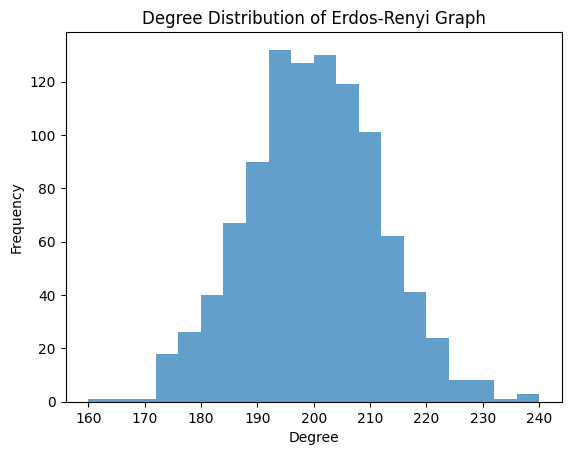

In [3]:
# Generate upper triangular part of adjacency matrix
upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)

# Ensure symmetry by setting upper triangular part equal to lower triangular part
A = upper_triangular + upper_triangular.T

# Plot degree distribution
degrees = np.sum(A, axis=0)
plt.hist(degrees, bins=20, alpha=0.7)
plt.title('Degree Distribution of Erdos-Renyi Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

Now we try to reproduce the result with the same code.

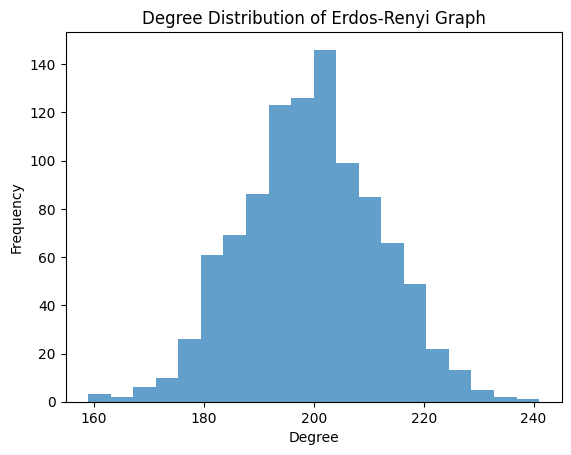

In [4]:
# Generate upper triangular part of adjacency matrix
upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)

# Ensure symmetry by setting upper triangular part equal to lower triangular part
A = upper_triangular + upper_triangular.T

# Plot degree distribution
degrees = np.sum(A, axis=0)
plt.hist(degrees, bins=20, alpha=0.7)
plt.title('Degree Distribution of Erdos-Renyi Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

We notice that the results are different for the two executions. This is because ```np.random.rand(n, n)``` generates different random values each time.

To reproduce the exact result, it is necessary to use the same random state for each execution. The random state refers to the complete state of the random number generator at a certain point in time. It includes all the information needed to reproduce the sequence of random numbers generated by the generator.

* ```random_state = np.random.get_state()``` retrieves the current state of the NumPy random number generator and stores it in the variable ```random_state```;
* ```np.random.set_state(random_state)``` sets the NumPy random state to the one in the specified```random_state``` variable.

For example:

In [5]:
# first execution, random state is saved:
random_state = np.random.get_state()
print(np.random.rand(5))

[0.8406547  0.48116122 0.26825114 0.51795996 0.29787364]


In [6]:
# second execution, saved random state is not loaded:
print(np.random.rand(5))

[0.16578029 0.64833793 0.02870773 0.27682003 0.00717987]


In [7]:
# third execution, saved random state is loaded:
np.random.set_state(random_state)
print(np.random.rand(5))

[0.8406547  0.48116122 0.26825114 0.51795996 0.29787364]


As we have seen, only by setting the same random state using ```np.random.set_state()```, can we ensure that the random numbers generated by NumPy are reproducible.

It is important to note that other libraries and functions might also use random number generators internally. Thus, it is important to set the random states for those as well if we want reproducibility across your entire codebase.

## Preserving the random state

In this section we demonstrate a technique to save and load the random state for NumPy's random number generator. 

```Python
# save / load random state
f_random_state = 'sim-network-random_state.pickle'
force_rebuild = False

if os.path.isfile(f_random_state) and not force_rebuild:
    # reproduce
    with open(f_random_state, 'rb') as f:
        random_state = pickle.load(f)
    np.random.set_state(random_state)
else:
    # produce
    random_state = np.random.get_state()
    with open(f_random_state, 'wb') as f:
        pickle.dump(random_state, f)
```

Here's an explanation:

* ```f_random_state``` stores the file path where the random state will be saved or loaded from. This is set to ```sim-network-random_state.pickle```.

* ```force_rebuild``` is a boolean variable that controls whether to force the code to rebuild the random state or load it from a saved file. If ```force_rebuild``` is True, the code will rebuild the random state; otherwise, it will attempt to load it from the saved file.

The code then checks if the file containing the random state exists (```os.path.isfile(f_random_state)```) and whether the code is not forced to rebuild the random state (```not force_rebuild```).

* If the saved random state file exists and ```force_rebuild``` is set to False, we are reproducing the result in a previous experiment in which the random state was saved. The code loads the random state from the file using ```pickle.load(f)```. ```pickle``` is a Python module used for serializing and deserializing Python objects.
The loaded random state is then set using ```np.random.set_state(random_state)```. This ensures that the random number generator will produce the same sequence of random numbers as it did when the state was saved.

* If the saved random state file does not exist or if ```force_rebuild``` is True, we are conducting a new experiment and wish to save the random state in order to reproduce the result later.The code generates a new random state using ```np.random.get_state()```. The generated random state is then saved to the file using ```pickle.dump(random_state, f)```.

Now, we use this technique to reproduce the degree distribution of the Erdos-Renyi graph in a previous experiment, in which the NumPy random state was saved to ```sim-network-random_state.pickle```. The reproduced plot and the result of the previous experiment ```sim-degree-distribution.pdf``` should be the same.

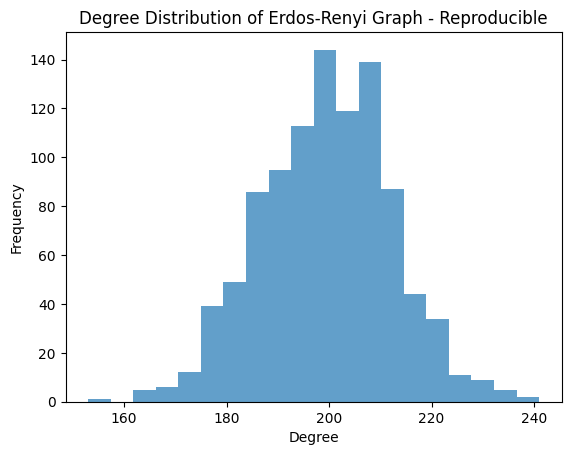

In [14]:
# save / load random state
f_random_state = 'sim-network-random_state.pickle'
force_rebuild = False

if os.path.isfile(f_random_state) and not force_rebuild:
    # reproduce
    with open(f_random_state, 'rb') as f:
        random_state = pickle.load(f)
    np.random.set_state(random_state)
else:
    # produce
    random_state = np.random.get_state()
    with open(f_random_state, 'wb') as f:
        pickle.dump(random_state, f)
        
# Generate upper triangular part of adjacency matrix
upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)

# Ensure symmetry by setting upper triangular part equal to lower triangular part
A = upper_triangular + upper_triangular.T

# Plot degree distribution
degrees = np.sum(A, axis=0)
plt.hist(degrees, bins=20, alpha=0.7)
plt.title('Degree Distribution of Erdos-Renyi Graph - Reproducible')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## Avoid cherry-picking